# Validate PFAS PBK model implementation in Antimony

In [46]:
import math
import pandas as pd
import tellurium as te
import matplotlib.pyplot as plt

fn_ant = '../model/PBK_PFAS.ant'


In [47]:
r = te.loada(fn_ant)

In [48]:
# Helper function for plotting simulation results
def plotSimulationResults(res, selections, ncols=4):
    nrows = math.ceil((len(selections) - 1)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()
    for ax in axes:
        ax.set(xlabel='time') 
    labels = selections
    for i in range(1, len(selections)):
        sid = selections[i]
        axes[i-1].plot(res['time'], res[sid])
        axes[i-1].set(ylabel=f"Amount", title=labels[i])
    for j in range(len(selections), nrows*ncols + 1):
        fig.delaxes(axes[j-1])
    fig.tight_layout()

def loadParametrisation(model, filename):
    df = pd.read_csv(filename)
    df['Value'] = df['Value'].astype(float)
    for index, row in df.iterrows():
        model[str(row['Parameter'])] = row['Value']


# Simulate daily oral dosing

Simulate model with daily oral dosing provided as a repetitively triggered event.

In [49]:
# Load the PBPK model from the SBML file
rr_model = te.loada(fn_ant)

# Specify the input
input_id = 'AG'

# Make sure A_gut is not constant and does not have boundary conditions
rr_model.setInitAmount(input_id, 0)
rr_model.setConstant(input_id, False)
rr_model.setBoundary(input_id, False)

# Remove all events
for event_id in rr_model.model.getEventIds():
    rr_model.removeEvent(event_id)

bw = 70
daily_intake = 3.55 * 0.011 * bw # ug/d (0.00355 mg/l * 11 mL/kg/day)

days_of_exposure = 30 * 365
days_after_exposure = 10 * 365
num_days = days_of_exposure + days_after_exposure

# Set chemical parameters
loadParametrisation(rr_model, '../Parametrisations/PFOA_Human.csv')
rr_model.QLC = 0.25

# Set physiological parameters
rr_model.BW = bw

# Create a repeating daily oral dosing
eid = f"oral_daily_exposure"
rr_model.addEvent(eid, False, f"time % 1 == 0 && time < {days_of_exposure}", False)
rr_model.addEventAssignment(eid, input_id, f"{input_id} + {daily_intake}", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
results = rr_model.simulate(0, num_days, num_days + 1)


## Report results

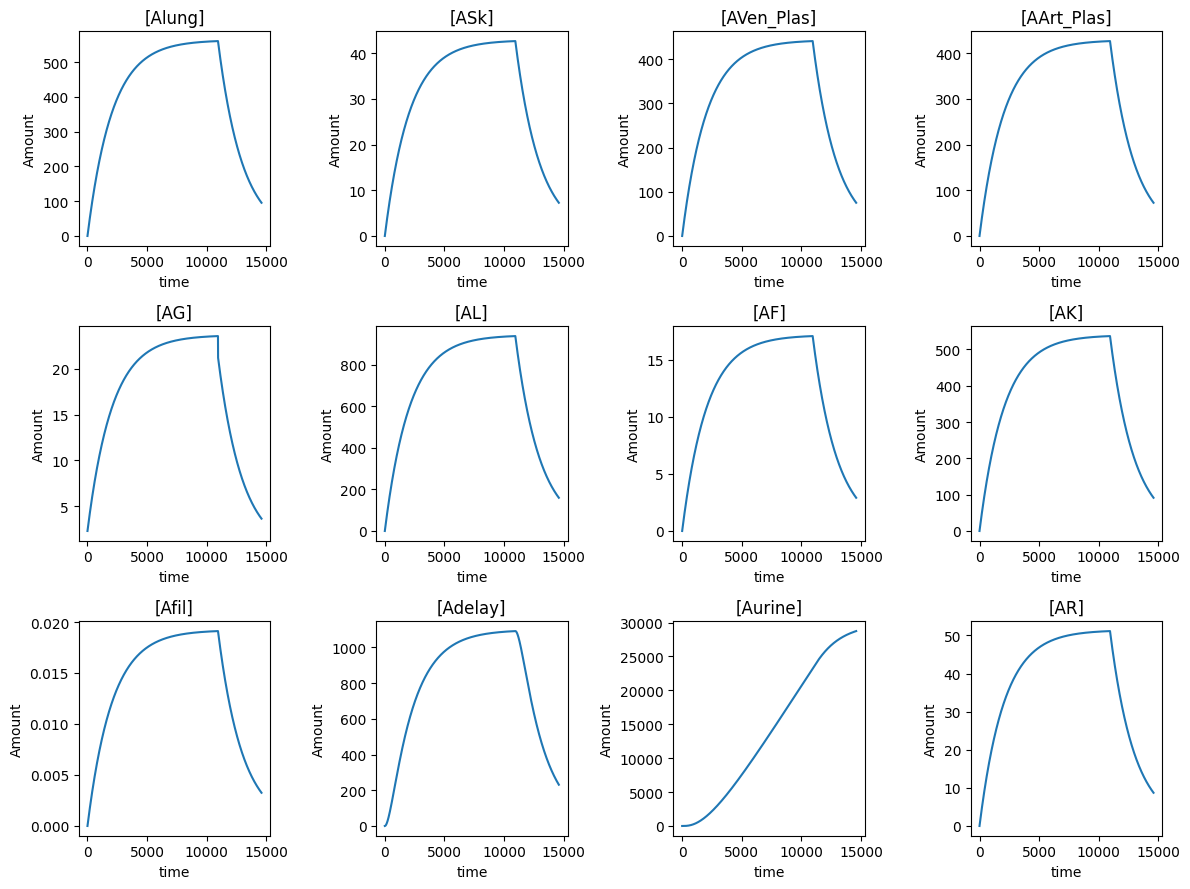

In [50]:
# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)


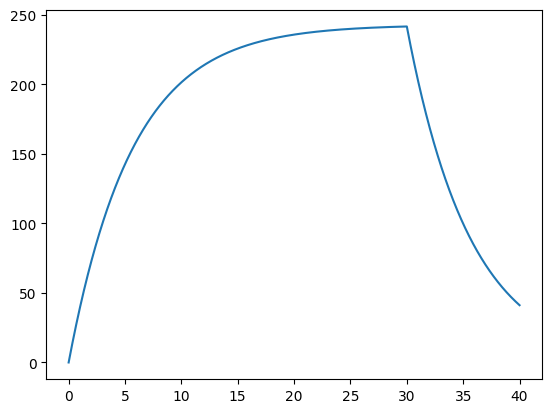

In [51]:
compartment = "Ven_Plas"
speciesId = "[AVen_Plas]"

x = results['time']
y = (results[speciesId] / rr_model[compartment])
plt.plot(x/365, y)
plt.title = compartment
plt.xlabel = 'Time (y)'
plt.ylabel = 'Concentration (ug/L)'

# Simulate with BW corrected doses

In [54]:
# Load the PBPK model from the SBML file
rr_model = te.loada(fn_ant)

# Specify the input
input_id = 'AG'

# Make sure A_gut is not constant and does not have boundary conditions
rr_model.setInitAmount(input_id, 0)
rr_model.setConstant(input_id, False)
rr_model.setBoundary(input_id, False)

# Remove all events
for event_id in rr_model.model.getEventIds():
    rr_model.removeEvent(event_id)

daily_intake = 3.55 * 0.011 # ug/d (0.00355 mg/l * 11 mL/kg/day)

days_of_exposure = 30 * 365
days_after_exposure = 10 * 365
num_days = days_of_exposure + days_after_exposure

# Set chemical parameters
loadParametrisation(rr_model, '../Parametrisations/PFOA_Human_Loccisano_2011.csv')

# Set physiological parameters
rr_model.BW = bw

# Create a repeating daily oral dosing
eid = f"oral_daily_exposure"
rr_model.addEvent(eid, False, f"time % 1 == 0 && time < {days_of_exposure}", False)
rr_model.addEventAssignment(eid, input_id, f"{input_id} + BW * {daily_intake}", False)
rr_model.regenerateModel(True, True)

plot_params = rr_model.timeCourseSelections + ['BW']

# Simulate the PBPK model
results = rr_model.simulate(0, num_days, num_days + 1, plot_params)


0.039049999999999994


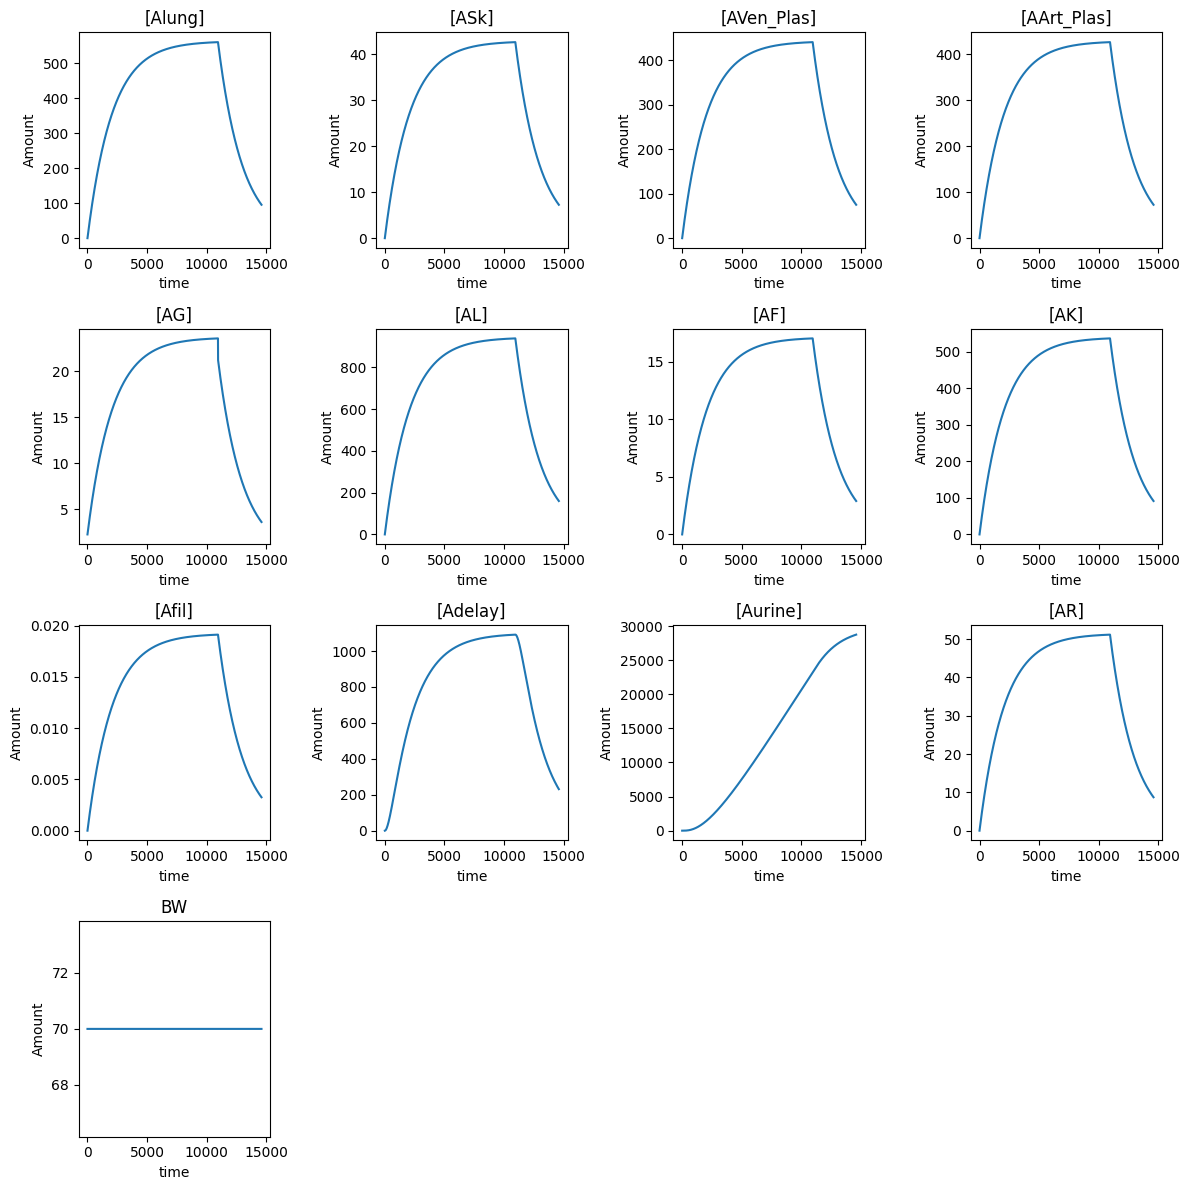

In [53]:
# Plot the results
plotSimulationResults(results, plot_params)